In [1]:
#Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from prettytable import PrettyTable
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import confusion_matrix
from keras.optimizers import Adam,RMSprop,SGD
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
from scipy import stats

def windows(data,size):
    start = 0
    while start< data.count():
        yield int(start), int(start + size)
        start+= (size/2)    

## our segmentation function to get streams of 128 samples in each timestep 
def segment_signal(data, window_size = 128):
    segments = np.empty((0,window_size,6))
    labels= np.empty((0))
    subjects = np.empty((0))

    for (start, end) in windows(data['Activity_acc'],window_size):
        x = data['x_acc'][start:end]
        y = data['y_acc'][start:end]
        z = data['z_acc'][start:end]
        p = data['x_gyro'][start:end]
        q = data['y_gyro'][start:end]
        r = data['z_gyro'][start:end]

        if(len(data['Activity_acc'][start:end])==window_size):
            segments = np.vstack([segments,np.dstack([x,y,z,p,q,r])])
            if labels is not None:
                labels = np.append(labels,stats.mode(data['Activity_acc'][start:end])[0][0])
    labels = pd.get_dummies(labels).to_numpy()
    return segments, labels

In [3]:
#Reading the accelerometer and gyroscope sensor measurements
df_acc = pd.read_csv('DataCollection_acc.csv', sep=";")
df_gyr = pd.read_csv('DataCollection_gyro.csv', sep=";")

In [4]:
#Joining the two datasource via the timestamp values
res = df_acc.set_index("time").join(df_gyr.set_index("time"), lsuffix='_acc', rsuffix='_gyro', on="time", how="inner")

In [5]:
X_train, Y_train = segment_signal(res, 64)

<ipython-input-2-b412698d8c10>:26: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  labels = np.append(labels,stats.mode(data['Activity_acc'][start:end])[0][0])
<ipython-input-2-b412698d8c10>:26: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  labels = np.append(labels,stats.mode(data['Activity_acc'][start:end])[0][0])


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.20, shuffle= True)

In [7]:
#initializing parameters
n_timesteps  = X_train.shape[1] #64 timesteps basically
n_outputs = Y_train.shape[1]  #3 outputs as we have 3-label classification
n_features =X_train.shape[2] #6 readings at each timestep

print("Number of timesteps :{}".format(n_timesteps))
print("Number of Outputs :{}".format(n_outputs))
print("Number of Features of each timestep :{}".format(n_features))

Number of timesteps :64
Number of Outputs :3
Number of Features of each timestep :6


In [8]:
n_hidden =64
batch_size = 4
epochs = 200
drop_out = 0.5

# fix random seed for reproducibility
seed = 329
np.random.seed(seed)

#Initiliazing the sequential model
model = Sequential()
#Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(n_timesteps, n_features)))
#Adding a dropout layer
model.add(Dropout(drop_out))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_outputs, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18176     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 18,371
Trainable params: 18,371
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
# Training the model
history=model.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

Epoch 1/200
99/99 [==============================] - 9s 11ms/step - loss: 0.9012 - accuracy: 0.5152 - val_loss: 0.7135 - val_accuracy: 0.5758
Epoch 2/200
99/99 [==============================] - 1s 6ms/step - loss: 0.6559 - accuracy: 0.6015 - val_loss: 0.7459 - val_accuracy: 0.5657
Epoch 3/200
99/99 [==============================] - 1s 7ms/step - loss: 0.6215 - accuracy: 0.6091 - val_loss: 0.7497 - val_accuracy: 0.5657
Epoch 4/200
99/99 [==============================] - 1s 7ms/step - loss: 0.6268 - accuracy: 0.6447 - val_loss: 0.6910 - val_accuracy: 0.5960
Epoch 5/200
99/99 [==============================] - 1s 7ms/step - loss: 0.6235 - accuracy: 0.6320 - val_loss: 0.6940 - val_accuracy: 0.6465
Epoch 6/200
99/99 [==============================] - 1s 9ms/step - loss: 0.5949 - accuracy: 0.6650 - val_loss: 0.6985 - val_accuracy: 0.5455
Epoch 7/200
99/99 [==============================] - 1s 9ms/step - loss: 0.5844 - accuracy: 0.6396 - val_loss: 0.7533 - val_accuracy: 0.6566
Epoch 8/200


In [10]:
#lists for appending the results of each model
train_loss_list =[];
test_loss_list =[];
train_accuracy_list =[];
test_accuracy_list = []

##evaluating on test-data
[test_loss, test_acc] = model.evaluate(X_test, Y_test)
[train_loss, train_acc] = model.evaluate(X_train, Y_train)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}%".format(test_loss, test_acc*100))
train_loss_list.append(train_loss)
test_loss_list.append(test_loss)
train_accuracy_list.append(train_acc)
test_accuracy_list.append(test_acc)

13/13 [==============================] - 0s 4ms/step - loss: 0.0315 - accuracy: 0.9873
Evaluation result on Test Data : Loss = 0.29161208868026733, accuracy = 94.94949579238892%


Text(0.5, 1.0, 'Categorical-CrossEntropy Curves')

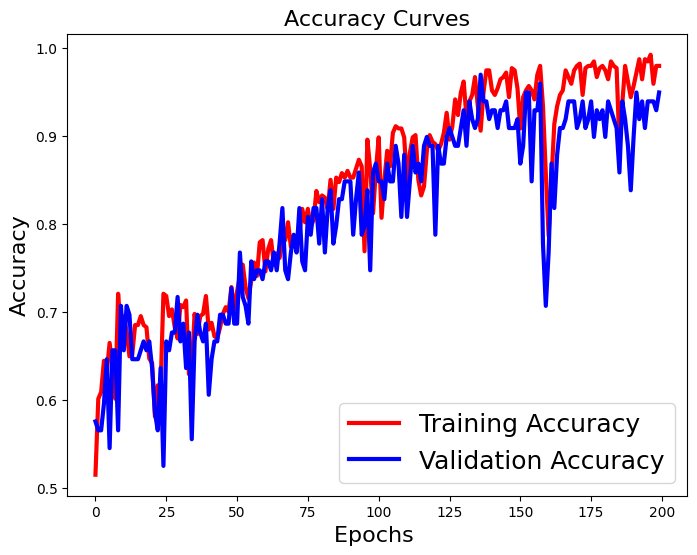

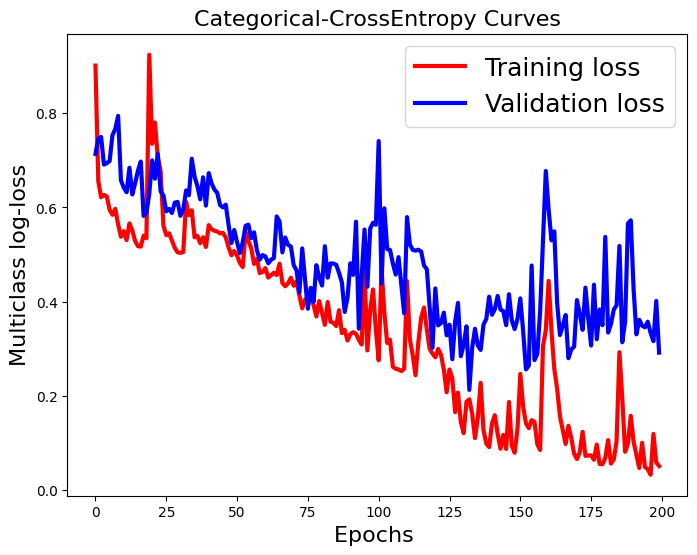

In [11]:
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

#Plot the loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Multiclass log-loss',fontsize=16)
plt.title('Categorical-CrossEntropy Curves',fontsize=16)

In [12]:
#index numbers of activities in one-hot encodeing
ACTIVITIES1 = {0: 'WALKING', 1: 'SITTING', 2: 'STANDING'}
# Utility function to get the predicted labels from probabilities
def confusion_labels(Y_t, Y_p):
    Y_true = pd.Series([ACTIVITIES1[y] for y in np.argmax(Y_t, axis=1)])
    Y_pred = pd.Series([ACTIVITIES1[y] for y in np.argmax(Y_p, axis=1)])
    return Y_true ,Y_pred

In [13]:
#getting the label names of test and predicted values 
Y_true ,Y_pred = (confusion_labels(Y_test, model.predict(X_test)))

4/4 [==============================] - 0s 4ms/step


In [14]:
# This function plots the confusion matrix.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)   
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(18,10))
    labels = [ 'WALKING','SITTING', 'STANDING']
    # representing A in heatmap format
    cmap=sns.light_palette("red")
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    plt.show()

+------------------+----------------+
| metric/parameter |     result     |
+------------------+----------------+
|      Model       | Classification |
|    optimizer     |      Adam      |
|     Dropout      |      0.5       |
|  Train-logloss   |      0.03      |
|   Test-logloss   |      0.29      |
|  Train-accuracy  |     98.73      |
|  Test-accuracy   |     94.95      |
+------------------+----------------+


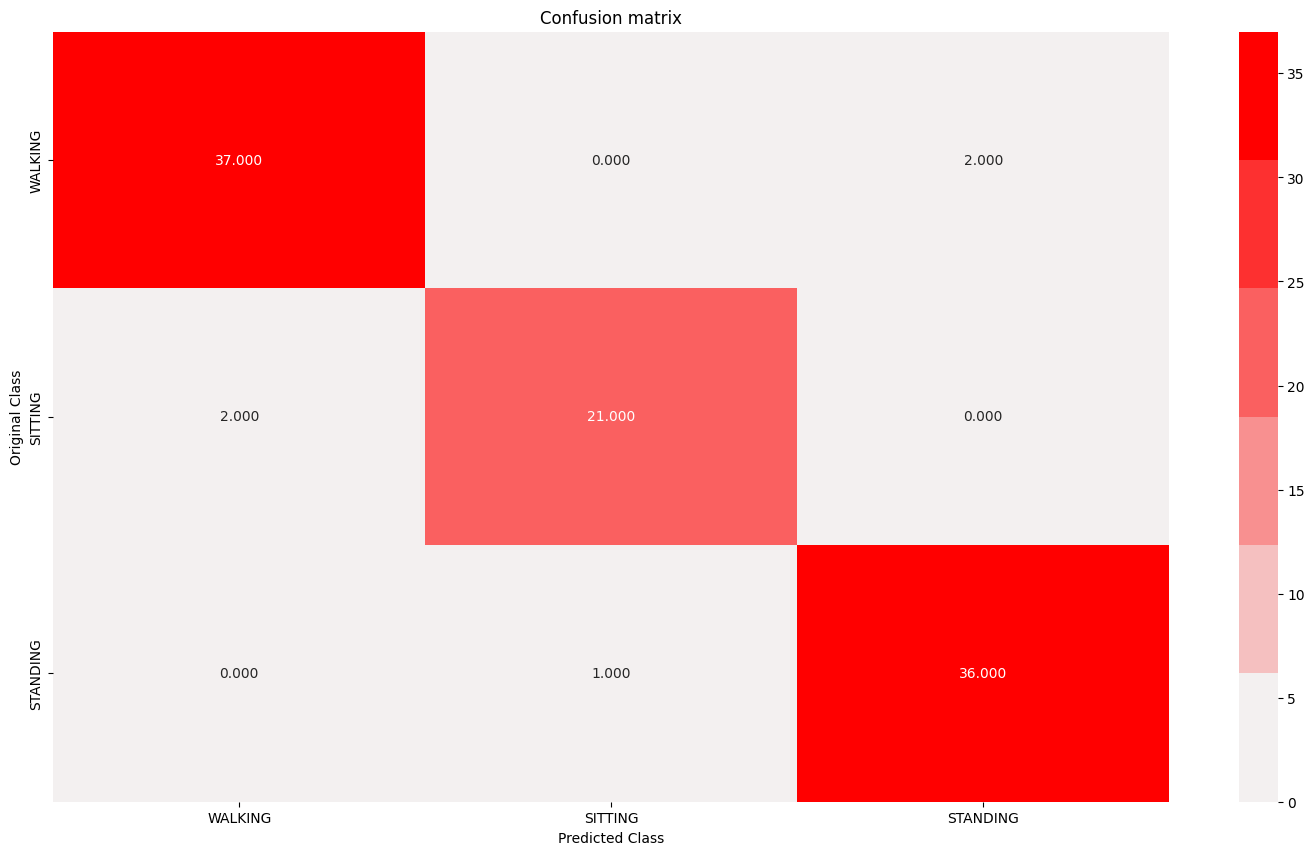

In [15]:
#reporting the results in a table
order_list = [0]

from prettytable import PrettyTable
for i in order_list:
  t= PrettyTable()
  t.field_names =["metric/parameter" , "result"]
  t.add_row (["Model" ,"Classification"])
  t.add_row(["optimizer","Adam"])
  t.add_row(["Dropout",0.5])
  t.add_row (["Train-logloss" ,round(train_loss_list[i],2)])
  t.add_row (["Test-logloss" ,round(test_loss_list[i],2)])
  t.add_row(["Train-accuracy",round(train_accuracy_list[i]*100,2)])
  t.add_row(["Test-accuracy",round(test_accuracy_list[i]*100,2)])
  print(t)
    
plot_confusion_matrix(Y_true,Y_pred)   

In [16]:
#Converting and saving the model in tensorflow lite format
import tensorflow as tf
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
tf.lite.OpsSet.SELECT_TF_OPS]

tfmodel = converter.convert()
open('model.tflite', 'wb').write(tfmodel)

30200